In [1]:
import findspark
findspark.init()

In [2]:
import pyspark

In [3]:
spark = pyspark.sql.SparkSession\
        .builder \
        .master("yarn") \
        .appName("ch05") \
        .config("spark.submit.deployMode", "client") \
        .config("spark.executor.memory", "2g") \
        .config("spark.driver.memory", "2g") \
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/11 17:09:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/11 17:09:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/05/11 17:09:09 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [4]:
spark.sparkContext

<SparkContext master=yarn appName=ch05>

In [5]:
df = spark.read.format("json").load("hdfs:///data/flight-data/json/2015-summary.json")

In [37]:
### Creting sql table
df.createOrReplaceTempView("flight_2015")

#### Check schema

In [6]:
# check schema
df.printSchema()

root
 |-- DEST_COUNTRY_NAME: string (nullable = true)
 |-- ORIGIN_COUNTRY_NAME: string (nullable = true)
 |-- count: long (nullable = true)



In [7]:
df.schema

StructType([StructField('DEST_COUNTRY_NAME', StringType(), True), StructField('ORIGIN_COUNTRY_NAME', StringType(), True), StructField('count', LongType(), True)])

#### Manual Schema

In [9]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, LongType

In [10]:
manualSchema = StructType(
    [
        StructField("DEST_COUNTRY_NAME", StringType(), True),
        StructField("ORIGIN_COUNTRY_NAME", StringType(), True),
        StructField("count", LongType(), False)
    ]
)

In [11]:
df1 = spark.read.schema(manualSchema).format("json").load("hdfs:///data/flight-data/json/2015-summary.json")
df1.schema 

StructType([StructField('DEST_COUNTRY_NAME', StringType(), True), StructField('ORIGIN_COUNTRY_NAME', StringType(), True), StructField('count', LongType(), True)])

In [14]:
# list columns
df.columns

['DEST_COUNTRY_NAME', 'ORIGIN_COUNTRY_NAME', 'count']

#### Creating Rows

In [16]:
from pyspark.sql import Row

In [20]:
# row object
myRow = Row("Cat", "Coco", 8)

In [18]:
myRow[1]

'Coco'

#### Creating Dataframe

In [22]:
manualSchema = StructType(
    [
        StructField("animal", StringType(), True),
        StructField("name", StringType(), True),
        StructField("age", LongType(), False)
    ]
)

In [23]:
myDf = spark.createDataFrame([myRow], manualSchema)
myDf.show()

+------+----+---+
|animal|name|age|
+------+----+---+
|   Cat|Coco|  8|
+------+----+---+



#### select and selectExpr

In [29]:
from pyspark.sql.functions import col, expr, column

In [27]:
df.printSchema()

root
 |-- DEST_COUNTRY_NAME: string (nullable = true)
 |-- ORIGIN_COUNTRY_NAME: string (nullable = true)
 |-- count: long (nullable = true)



In [28]:
df.select("DEST_COUNTRY_NAME", "ORIGIN_COUNTRY_NAME").show(2)

+-----------------+-------------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|
+-----------------+-------------------+
|    United States|            Romania|
|    United States|            Croatia|
+-----------------+-------------------+
only showing top 2 rows



In [33]:
df.select(
    "DEST_COUNTRY_NAME",
    col("ORIGIN_COUNTRY_NAME"),
    column("count"),
    col("ORIGIN_COUNTRY_NAME").alias("original_country_name"),
    expr("DEST_COUNTRY_NAME as dest_country_name")
).show(2)

+-----------------+-------------------+-----+---------------------+-----------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|original_country_name|dest_country_name|
+-----------------+-------------------+-----+---------------------+-----------------+
|    United States|            Romania|   15|              Romania|    United States|
|    United States|            Croatia|    1|              Croatia|    United States|
+-----------------+-------------------+-----+---------------------+-----------------+
only showing top 2 rows



In [ ]:
# selectExpr() expects strings as input
df.selectExpr("*", "(DEST_COUNTRY_NAME = ORIGIN_COUNTRY_NAME) as withinCountry").show(5)

+-----------------+-------------------+-----+-------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|withinCountry|
+-----------------+-------------------+-----+-------------+
|    United States|            Romania|   15|        false|
|    United States|            Croatia|    1|        false|
|    United States|            Ireland|  344|        false|
|            Egypt|      United States|   15|        false|
|    United States|              India|   62|        false|
+-----------------+-------------------+-----+-------------+
only showing top 5 rows



In [36]:
df.selectExpr("AVG(count)", "COUNT(DISTINCT(DEST_COUNTRY_NAME))").show()

+-----------+---------------------------------+
| avg(count)|count(DISTINCT DEST_COUNTRY_NAME)|
+-----------+---------------------------------+
|1770.765625|                              132|
+-----------+---------------------------------+



#### Literals

In [42]:
from pyspark.sql.functions import lit
df.select(expr("*"), lit(1).alias("one")).show(2)

+-----------------+-------------------+-----+---+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|one|
+-----------------+-------------------+-----+---+
|    United States|            Romania|   15|  1|
|    United States|            Croatia|    1|  1|
+-----------------+-------------------+-----+---+
only showing top 2 rows



In [43]:
spark.sql("""
    select *, 1 as one
          from flight_2015    
""").show(2)

+-----------------+-------------------+-----+---+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|one|
+-----------------+-------------------+-----+---+
|    United States|            Romania|   15|  1|
|    United States|            Croatia|    1|  1|
+-----------------+-------------------+-----+---+
only showing top 2 rows



In [47]:
df.selectExpr("*", "1 as one").show(2)

+-----------------+-------------------+-----+---+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|one|
+-----------------+-------------------+-----+---+
|    United States|            Romania|   15|  1|
|    United States|            Croatia|    1|  1|
+-----------------+-------------------+-----+---+
only showing top 2 rows



#### withColumn

In [49]:
df.withColumn("One", expr("1 as one")).show(2)

+-----------------+-------------------+-----+---+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|One|
+-----------------+-------------------+-----+---+
|    United States|            Romania|   15|  1|
|    United States|            Croatia|    1|  1|
+-----------------+-------------------+-----+---+
only showing top 2 rows



In [51]:
df.withColumn("withinCountry", expr("DEST_COUNTRY_NAME = ORIGIN_COUNTRY_NAME")).show(2)

+-----------------+-------------------+-----+-------------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|withinCountry|
+-----------------+-------------------+-----+-------------+
|    United States|            Romania|   15|        false|
|    United States|            Croatia|    1|        false|
+-----------------+-------------------+-----+-------------+
only showing top 2 rows



#### Removing Columns

In [53]:
df.drop("count").columns

['DEST_COUNTRY_NAME', 'ORIGIN_COUNTRY_NAME']

#### Changing type

In [60]:
from pyspark.sql.functions import cast
df.withColumn("countLong", cast("long", col("count"))).show(2)

+-----------------+-------------------+-----+---------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|countLong|
+-----------------+-------------------+-----+---------+
|    United States|            Romania|   15|       15|
|    United States|            Croatia|    1|        1|
+-----------------+-------------------+-----+---------+
only showing top 2 rows



In [61]:
df.withColumn("countLong", col("count").cast("long")).show(2)

+-----------------+-------------------+-----+---------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|countLong|
+-----------------+-------------------+-----+---------+
|    United States|            Romania|   15|       15|
|    United States|            Croatia|    1|        1|
+-----------------+-------------------+-----+---------+
only showing top 2 rows



In [63]:
spark.sql("""
    select *, cast(count as long) as countLong
    from flight_2015
""").show(2)

+-----------------+-------------------+-----+---------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|countLong|
+-----------------+-------------------+-----+---------+
|    United States|            Romania|   15|       15|
|    United States|            Croatia|    1|        1|
+-----------------+-------------------+-----+---------+
only showing top 2 rows



#### Filtering rows

In [ ]:
# using filter
df.filter(col("count") > 2).show(2)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|   15|
|    United States|            Ireland|  344|
+-----------------+-------------------+-----+
only showing top 2 rows



In [ ]:
df.where("count > 2").show(2)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|   15|
|    United States|            Ireland|  344|
+-----------------+-------------------+-----+
only showing top 2 rows



In [69]:
# multiple AND

df.where(col("count") > 2).where(col("ORIGIN_COUNTRY_NAME") == "Romania").show(2)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|   15|
+-----------------+-------------------+-----+



#### Unique Rows

In [70]:
df.select(expr("*")).distinct().show(2)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|          Curacao|      United States|   90|
|           Poland|      United States|   32|
+-----------------+-------------------+-----+
only showing top 2 rows



In [71]:
df.selectExpr("*").distinct().count()

256

In [72]:
df.select("DEST_COUNTRY_NAME", "ORIGIN_COUNTRY_NAME").distinct().count()

256

In [74]:
spark.sql("""
    select count(distinct(DEST_COUNTRY_NAME, ORIGIN_COUNTRY_NAME)) as distinct_count
    from flight_2015
""").show()

+--------------+
|distinct_count|
+--------------+
|           256|
+--------------+



#### Random Sample

In [101]:
df.sample(withReplacement=False, fraction=0.1, seed=29).show(5)

+--------------------+-------------------+-----+
|   DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+--------------------+-------------------+-----+
|       United States|            Croatia|    1|
|             Moldova|      United States|    1|
|Turks and Caicos ...|      United States|  230|
|            Suriname|      United States|    1|
|           Venezuela|      United States|  290|
+--------------------+-------------------+-----+
only showing top 5 rows



#### Random Splits

In [86]:
split_df = df.randomSplit(weights=[0.25, 0.75])

In [88]:
split_df[0].count(), split_df[1].count()

(45, 211)

#### Concating and Appending Rows

In [99]:
df2 = df.where("DEST_COUNTRY_NAME = 'Italy'")
df2.show()

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|            Italy|      United States|  382|
+-----------------+-------------------+-----+



In [103]:
df3 = df.where("DEST_COUNTRY_NAME = 'India'")
df3.show()

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|            India|      United States|   61|
+-----------------+-------------------+-----+



In [104]:
df2.union(df3).show()

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|            Italy|      United States|  382|
|            India|      United States|   61|
+-----------------+-------------------+-----+



#### Sorting Rows

In [106]:
df.sort("count").show(5)

+--------------------+-------------------+-----+
|   DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+--------------------+-------------------+-----+
|               Malta|      United States|    1|
|Saint Vincent and...|      United States|    1|
|       United States|            Croatia|    1|
|       United States|          Gibraltar|    1|
|       United States|          Singapore|    1|
+--------------------+-------------------+-----+
only showing top 5 rows



In [107]:
df.orderBy("count").show(5)

+--------------------+-------------------+-----+
|   DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+--------------------+-------------------+-----+
|               Malta|      United States|    1|
|Saint Vincent and...|      United States|    1|
|       United States|            Croatia|    1|
|       United States|          Gibraltar|    1|
|       United States|          Singapore|    1|
+--------------------+-------------------+-----+
only showing top 5 rows



In [113]:
from pyspark.sql.functions import desc, asc

df.orderBy(col("count").desc()).show(5)

+-----------------+-------------------+------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME| count|
+-----------------+-------------------+------+
|    United States|      United States|370002|
|    United States|             Canada|  8483|
|           Canada|      United States|  8399|
|    United States|             Mexico|  7187|
|           Mexico|      United States|  7140|
+-----------------+-------------------+------+
only showing top 5 rows



In [114]:
df.orderBy(desc(col("count"))).show(5)

+-----------------+-------------------+------+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME| count|
+-----------------+-------------------+------+
|    United States|      United States|370002|
|    United States|             Canada|  8483|
|           Canada|      United States|  8399|
|    United States|             Mexico|  7187|
|           Mexico|      United States|  7140|
+-----------------+-------------------+------+
only showing top 5 rows



In [128]:
df.orderBy(col("DEST_COUNTRY_NAME").asc(), col("ORIGIN_COUNTRY_NAME").desc()).show(5)

+-------------------+-------------------+-----+
|  DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-------------------+-------------------+-----+
|            Algeria|      United States|    4|
|             Angola|      United States|   15|
|           Anguilla|      United States|   41|
|Antigua and Barbuda|      United States|  126|
|          Argentina|      United States|  180|
+-------------------+-------------------+-----+
only showing top 5 rows



In [ ]:
#### sort within each partitions

In [134]:
spark.read \
    .format("json") \
    .load("hdfs:///data/flight-data/json/2015-summary.json") \
    .sortWithinPartitions("count")

DataFrame[DEST_COUNTRY_NAME: string, ORIGIN_COUNTRY_NAME: string, count: bigint]

#### Limit

In [136]:
df.limit(5).show()

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|   15|
|    United States|            Croatia|    1|
|    United States|            Ireland|  344|
|            Egypt|      United States|   15|
|    United States|              India|   62|
+-----------------+-------------------+-----+



#### Repartitons and Coalesce
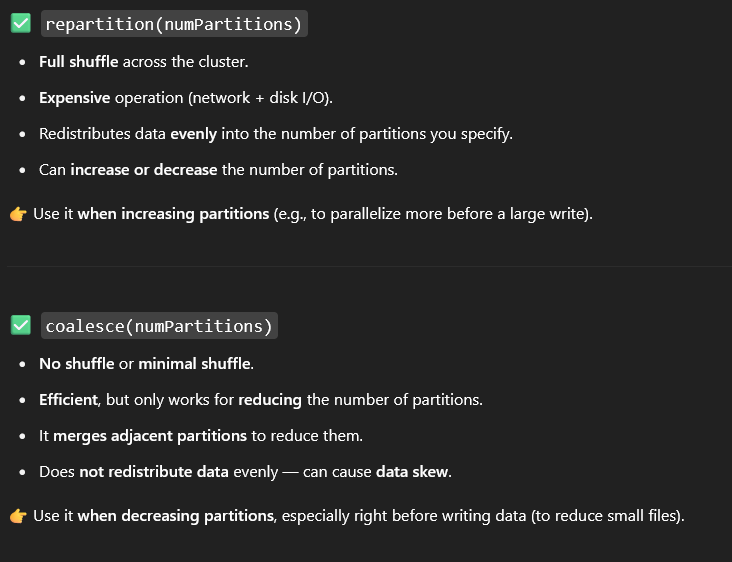

In [141]:
df.rdd.getNumPartitions()

1

In [140]:
df.repartition(5).rdd.getNumPartitions()

5

In [143]:
# partitions on specific column
df.repartition(5, col("DEST_COUNTRY_NAME"))

DataFrame[DEST_COUNTRY_NAME: string, ORIGIN_COUNTRY_NAME: string, count: bigint]

In [144]:
df.repartition(5, col("DEST_COUNTRY_NAME")).coalesce(2)

DataFrame[DEST_COUNTRY_NAME: string, ORIGIN_COUNTRY_NAME: string, count: bigint]

In [ ]:
        #   ┌──────────┐
        #   │  JOB     │ ← triggered by an action (e.g., `show()`, `collect()`, `count()`)
        #   └────┬─────┘
        #        ↓
        #   ┌──────────┐
        #   │ STAGE(S) │ ← a stage is a set of transformations without shuffles
        #   └────┬─────┘
        #        ↓
        #  ┌────────────┐
        #  │  TASK(S)     ← each task runs on **one partition**
        #  └────────────┘


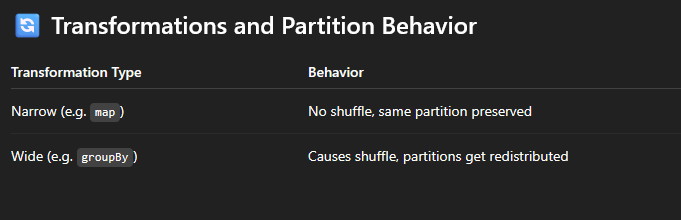

In [147]:
spark.stop()